## Imports

In [1]:
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists

import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
import sys
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython

In [9]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: steliobompai (synthetic-data-gan). Use `wandb login --relogin` to force relogin


acc,▁▁▃▆▇██▇
loss,██▆▂▁▄▃▃
acc,0.77982
loss,0.26704


## Preprocess the data

## Keras Tuner

## Model training and validation

In [6]:
import random as rn
from sklearn.model_selection import train_test_split


np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)
def training(epochs, TEST_X = 0, TEST_Y= 0, VAL_X = 0, VAL_Y= 0, TRAIN_X= 0, TRAIN_Y = 0, synthetic_data = None, synthetic = False, temp_perc = 0):

    data = pd.read_csv("../TimeGAN_PytorchRebuild/data/copper_data.csv")
    data = data / 1000
    # if synthetic_data is not None:
    gen_data = [pd.read_csv(csv) for csv in synthetic_data]
    # Variables for training
    cols = list(data)[0:16]
    gen_data = pd.concat(gen_data, axis=0, ignore_index=True)
    # dividing by 1000 to make the values less messsy
    print(gen_data['SUM'][0])
    gen_data = gen_data / 1000
    print(gen_data['SUM'][0])
    if temp_perc == 0:
        temp_perc = len(gen_data)
    # print(cols)
    # print (len(cols))
    scaler = MinMaxScaler(feature_range=(0, 1))

    
    # Scaling all together in order for consistency
    all_data = pd.concat([gen_data[:temp_perc], data], axis=0) # concatenate original and synthetic
    all_data = all_data[cols].astype(float)
    all_data = scaler.fit(all_data)


    df_for_training = data[cols].astype(float)
    print(f'Shape of DataFrame: {df_for_training.shape}')
    if synthetic:
        dfsyn_for_training = gen_data[:temp_perc][cols].astype(float)
        print(f'Shape of DataFrame: {dfsyn_for_training.shape}')
    
    
    df_for_training_scaled = scaler.transform(df_for_training)
    print(f'Shape of scaled DataFrame: {df_for_training_scaled.shape}')
    if synthetic:
        dfsyn_for_training_scaled = scaler.transform(dfsyn_for_training)
        print(f'Shape of scaled DataFrame: {dfsyn_for_training_scaled.shape}')
    
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    n_future = 1   # Number of days we want to look into the future based on the past days (Out).
    n_past = 15    # Number of past days we want to use to predict the future (Step).
    features = 15  # Number of features


    def column(matrix, i):
        return [row[i] for row in matrix]

    def split_sequence(seq, steps, out):
        X, Y = list(), list()
        for i in range(len(seq)):
            end = i + steps
            outi = end + out
            if outi > len(seq)-1:
                break
            seqx, seqy = seq[i:end], column(seq[end:outi],0) # 1 the column number I want to make the prediction
            X.append(seqx)
            Y.append(seqy)
        return np.array(X), np.array(Y)

    # TRAIN/VAL/TEST
    if not synthetic: # original training
        # split into samples
        X_train, Y_train = split_sequence(df_for_training_scaled, n_past, n_future)
        X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X_train, Y_train, test_size=0.5, random_state=42, shuffle= True)
        X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle= True)
        X_train, Y_train = X_train_temp, y_train_temp
    else: # synthetic training
        X_val, X_test, Y_val, Y_test, X_train_temp, y_train_temp = VAL_X, TEST_X, VAL_Y, TEST_Y, TRAIN_X, TRAIN_Y
        X_train_syn, Y_train_syn = split_sequence(dfsyn_for_training_scaled, n_past, n_future)
        X_train, Y_train = np.concatenate([X_train_temp, X_train_syn], axis=0), np.concatenate([y_train_temp, Y_train_syn], axis=0)


    print("X_test and Y_test are: \n")
    # print(X_test, Y_test)
    print(X_train.shape,Y_train.shape)
        

    print(X_train.shape,X_val.shape, X_test.shape)
    print(Y_train.shape,Y_val.shape, Y_test.shape)

    # print(Y_test.shape,Y_test.shape)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], features))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], features))

    print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)


    model = Sequential()
    model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(X_train.shape[1], X_train.shape[2]))))
    model.add(Bidirectional(LSTM(512, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(1024, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(2048, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(1024, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(n_future))
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=8, validation_data=(X_val, Y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=35)],
                        verbose=1, shuffle=True)

    # inverse transform predictions
    yhat = model.predict(X_test)
    zeros = np.zeros((X_test.shape[0],15))
    for i in range(zeros.shape[0]):
        zeros[i][0] = yhat[i]
    
    # print("shape of Zero: ", zeros)
    y_pred_future = scaler.inverse_transform(zeros)
    y_pred_future = [i[0] for i in y_pred_future]

    # y_actual = scaler.inverse_transform(Y_test)
    # print(y_actual)
    
    # y_actual = np.array(df_for_training.tail(X_test.shape[0])['SUM'])
    zeros = np.zeros((X_test.shape[0],15))
    for i in range(zeros.shape[0]):
        zeros[i][0] = Y_test[i]
    original = scaler.inverse_transform(zeros)
    original = [i[0] for i in original]
    print(original)
    # print(y_actual)
    print(y_pred_future)

    pyplot.figure(figsize=(20,8))
    pyplot.plot(y_pred_future, label='prediction', color="r")
    pyplot.plot(original, label='actual', marker='.')
    pyplot.legend()
    pyplot.ylabel('Energy', size=15)
    pyplot.xlabel('Time step', size=15)
    pyplot.legend(fontsize=15)

    pyplot.show()

    pyplot.plot(history.history['loss'], label='train', color="black")
    pyplot.plot(history.history['val_loss'], label='test',marker='.')
    pyplot.title('model loss',size=15)
    pyplot.ylabel('loss',size=15)
    pyplot.xlabel('epochs',size=15)
    pyplot.legend(loc='upper right',fontsize=15)

    pyplot.show()

    def mape(y_test, pred):
        y_test, pred = np.array(y_test), np.array(pred)
        mape = np.mean(np.abs((y_test - pred) / y_test))
        for i in range(y_test.shape[0]):
            print(np.abs((y_test[i] - pred[i]) / y_test[i]))
        return mape

    mape = mape(original, y_pred_future)
    print('Test Score: %.2f (MAPE)' % (mape))
    mae = mean_absolute_error(original, y_pred_future)
    print('Test Score: %.2f kWh (MAE)' % (mae))
    mse = mean_squared_error(original, y_pred_future)
    print('Test Score: %.2f (MSE)' % (mse))
    rmse = sqrt(mse)
    print('Test Score: %.2f (RMSE)' % (rmse))
    if not synthetic:
        return X_val, X_test, Y_val, Y_test, X_train_temp, y_train_temp

562721.2323079469
562.7212323079469
Shape of DataFrame: (38, 15)
Shape of scaled DataFrame: (38, 15)
X_test and Y_test are: 

(11, 15, 15) (11, 1)
(11, 15, 15) (5, 15, 15) (6, 15, 15)
(11, 1) (5, 1) (6, 1)
(11, 15, 15) (11, 1) (5, 15, 15) (5, 1)
Epoch 1/40


c:\Users\steli\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 84s 10s/step - loss: 0.3145 - mse: 0.3145 - val_loss: 0.4865 - val_mse: 0.4865
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 0.2431 - mse: 0.2431 - val_loss: 0.2483 - val_mse: 0.2483
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 0.1220 - mse: 0.1220 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 0.0970 - mse: 0.0970 - val_loss: 0.2956 - val_mse: 0.2956
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 0.1579 - mse: 0.1579 - val_loss: 0.1670 - val_mse: 0.1670
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 0.1262 - mse: 0.1262 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 0.0871 - mse: 0.0871 - val_loss: 0.2271 - val_mse: 0.2271
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - loss: 0.1168 - mse: 0.1168 - val_loss: 0.3112 - val_mse: 0.3112
Epoch 9/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 0.1551 - mse: 0.1551 - val_loss: 0.2729 - 

C:\Users\steli\AppData\Local\Temp\ipykernel_16752\3054999663.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = yhat[i]
C:\Users\steli\AppData\Local\Temp\ipykernel_16752\3054999663.py:132: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = Y_test[i]


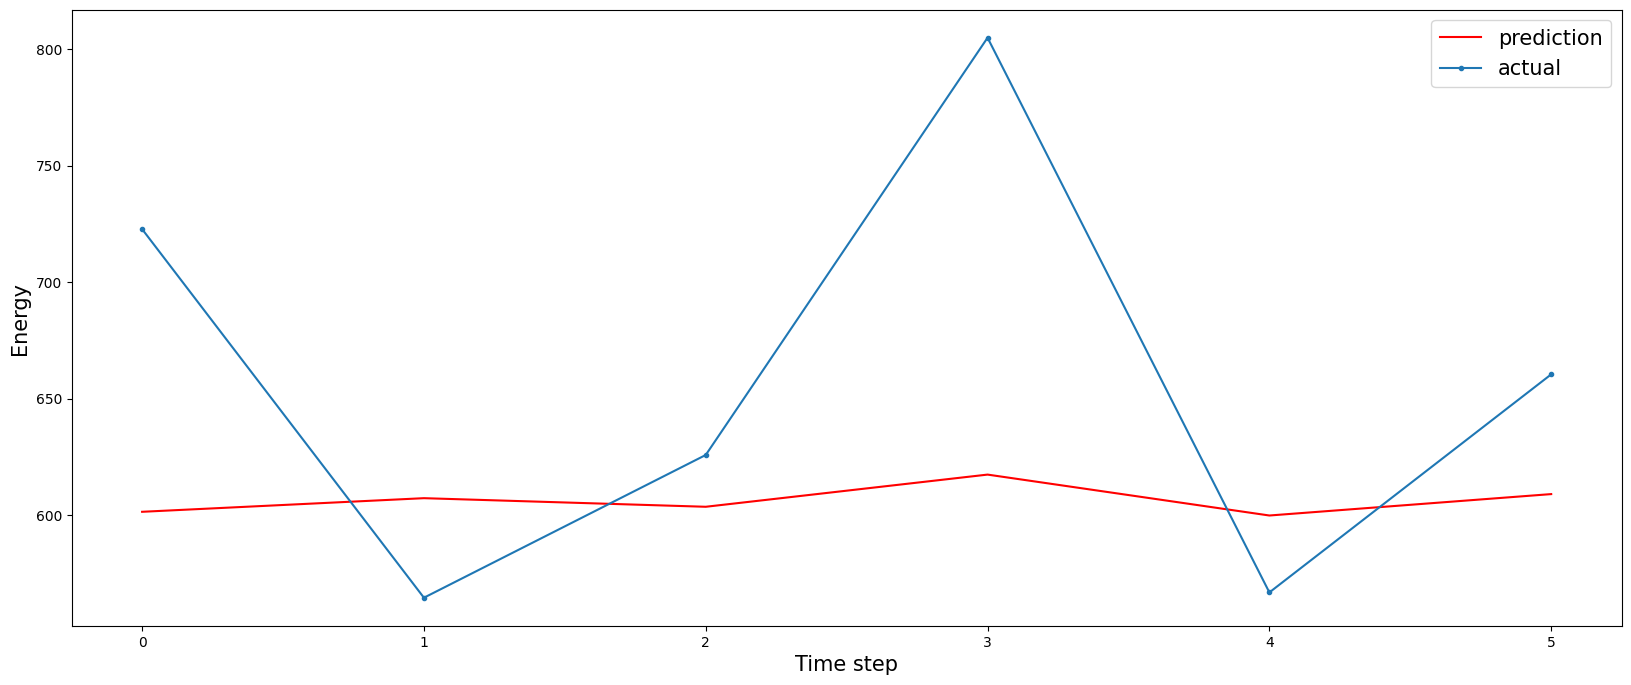

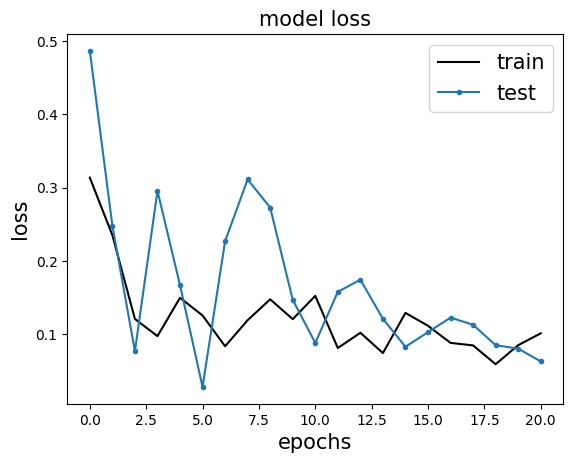

0.16787579121083437
0.07568547884197853
0.035524021628261605
0.2329682100452309
0.058245905871498055
0.07782341160327257
Test Score: 0.11 (MAPE)
Test Score: 76.37 kWh (MAE)
Test Score: 9323.12 (MSE)
Test Score: 96.56 (RMSE)


In [4]:
X_val, X_test, Y_val, Y_test, X_train_temp, y_train_temp = training(40, synthetic_data= ["./RTSGAN_gen_data.csv"]) # original training

562721.2323079469
562.7212323079469
Shape of DataFrame: (38, 15)
Shape of DataFrame: (37, 15)
Shape of scaled DataFrame: (38, 15)
Shape of scaled DataFrame: (37, 15)
X_test and Y_test are: 

(32, 15, 15) (32, 1)
(32, 15, 15) (5, 15, 15) (6, 15, 15)
(32, 1) (5, 1) (6, 1)
(32, 15, 15) (32, 1) (5, 15, 15) (5, 1)
Epoch 1/140


c:\Users\steli\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 118s 10s/step - loss: 0.3456 - mse: 0.3456 - val_loss: 0.5168 - val_mse: 0.5168
Epoch 2/140
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 0.2017 - mse: 0.2017 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 3/140
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 0.1514 - mse: 0.1514 - val_loss: 0.3474 - val_mse: 0.3474
Epoch 4/140
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 0.1272 - mse: 0.1272 - val_loss: 0.2841 - val_mse: 0.2841
Epoch 5/140
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 0.0826 - mse: 0.0826 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 6/140
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 0.1164 - mse: 0.1164 - val_loss: 0.2209 - val_mse: 0.2209
Epoch 7/140
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 0.0732 - mse: 0.0732 - val_loss: 0.2271 - val_mse: 0.2271
Epoch 8/140
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 0.0769 - mse: 0.0769 - val_loss: 0.1170 - val_mse: 0.1170
Epoch 9/140
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 0.0512 - mse: 0.0512 - val_loss: 

C:\Users\steli\AppData\Local\Temp\ipykernel_16752\1544681805.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = yhat[i]
C:\Users\steli\AppData\Local\Temp\ipykernel_16752\1544681805.py:132: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = Y_test[i]


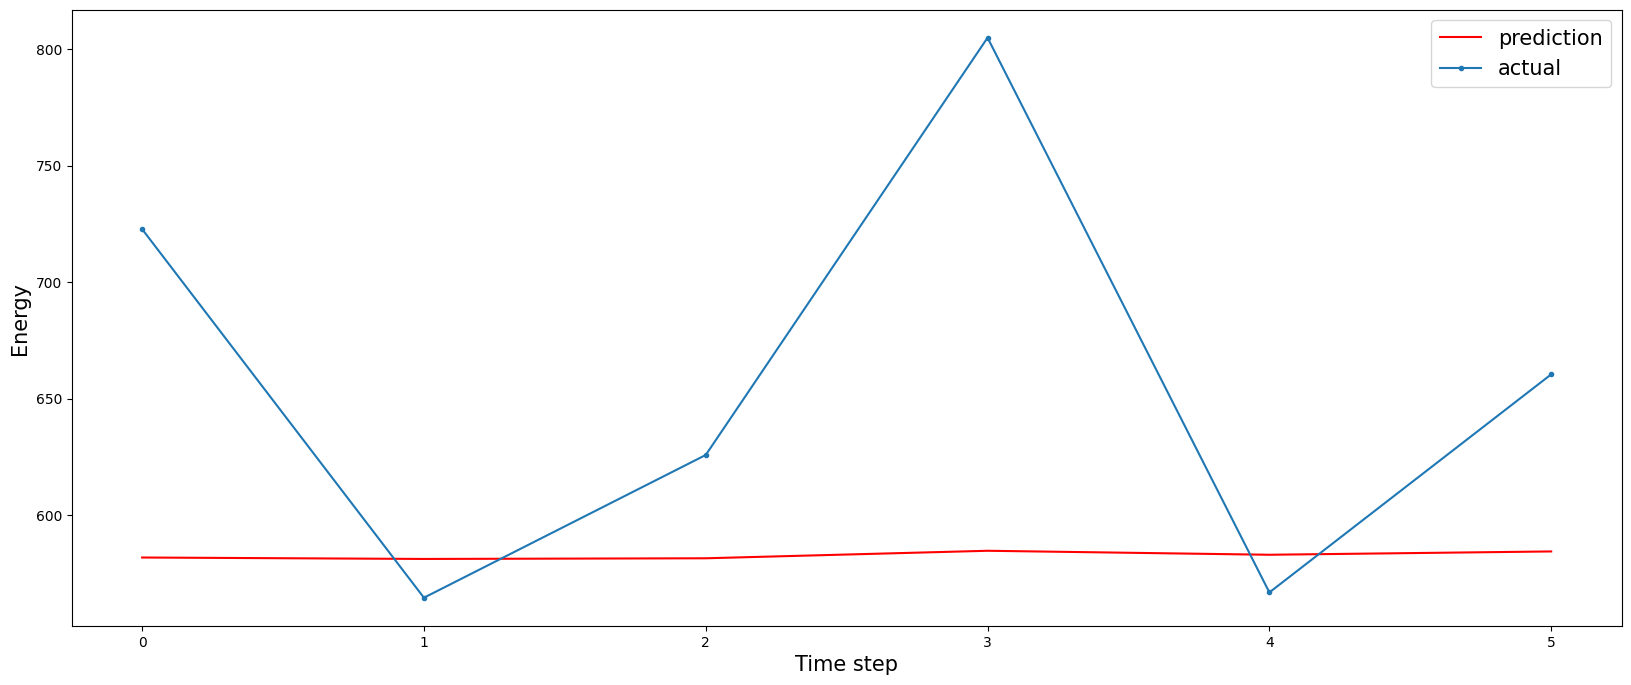

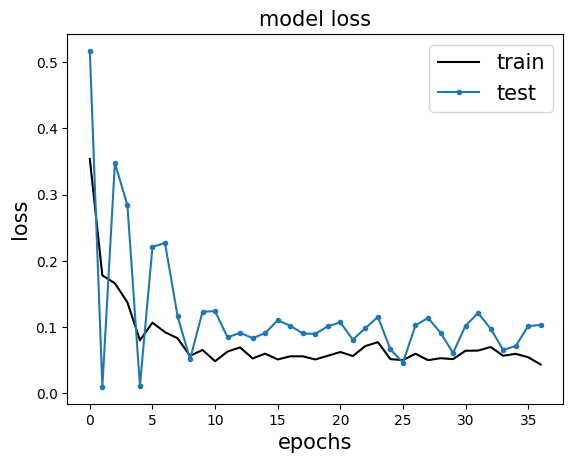

0.195025408959543
0.029480253909580638
0.07085236500302182
0.27358957563860353
0.02852382269284006
0.11509559031601058
Test Score: 0.12 (MAPE)
Test Score: 85.72 kWh (MAE)
Test Score: 12774.76 (MSE)
Test Score: 113.03 (RMSE)


In [7]:
training(140, X_test, Y_test, X_val, Y_val, X_train_temp, y_train_temp, synthetic_data= ["./RTSGAN_gen_data.csv"], synthetic= True) # synthetic training